## <span style='font-family:"Times New Roman"'>Importing libraries

In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np
import re
import emoji

from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion

import nltk
import string
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize        
from nltk.stem import WordNetLemmatizer 
from nltk.text import TextCollection

import seaborn as sns
import matplotlib.pyplot as plt

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/aw/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## <span style='font-family:"Times New Roman"'>Downloading datasets

In [2]:
"""Loading data-sets"""
df_train = pd.read_csv("https://www.dropbox.com/s/6gr5t05rd7v3nwm/dalc_v1_train_text.csv?dl=1")
df_dev = pd.read_csv("https://www.dropbox.com/s/mf2gyanb2pbz51a/dalc_v1_dev_text.csv?dl=1")
df_test = pd.read_csv("https://www.dropbox.com/s/ngotr4fyhjl9i2f/dalc_v1_test_text.csv?dl=1")
df_gold = pd.read_csv("https://www.dropbox.com/s/renwwgci14rs97z/df_gold.csv?dl=1")

## <span style='font-family:"Times New Roman"'>Processing labels & text

In [3]:
def clean_samples(data):
    """Cleaning the tweets"""
    new_samples = []
    content = list(data['Text'])
    for tweet_message in content:
        tweet_message = re.sub(r'https.*[^ ]', 'URL', tweet_message)
        tweet_message = re.sub(r'http.*[^ ]', 'URL', tweet_message)
        tweet_message = re.sub(r'@([^ ]*)', '@USER', tweet_message)
        tweet_message = emoji.demojize(tweet_message)
        tweet_message = re.sub(r'(:.*?:)', r' \1 ', tweet_message)
        tweet_message = re.sub(' +', ' ', tweet_message)
        new_samples.append(tweet_message)
    return new_samples

In [4]:
def heatmap(confusion_matrix, labels, color):
    """Create heatmap confusion matrix"""
    dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=dims)
    sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap=color, xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label") 
    plt.ylabel("True Label")
    plt.show()

In [5]:
def encode_labels(labels):
    """Encoding the labels to numerical values"""
    y_label = []
    for label in labels:
        if label == "EXPLICIT":
            y_label.append(2)
        elif label == "IMPLICIT":
            y_label.append(1)
        elif label == "NOT":
            y_label.append(0)
    return np.array(y_label)

In [6]:
def _tokenize(word):
    """Helper function"""
    return word.split(' ')

def tokenize_v1(text):
    """Basic tokenizer thats splits on whitespace"""
    for token in _tokenize(text):
        yield token

def word_tokenize_stem(text):
    """Custom tokenizzer with a stemmer"""
    stem = nltk.stem.SnowballStemmer('dutch')
    text = text.lower()
    for token in word_tokenize(text):
        yield stem.stem(token)
          
def bow(data):
    """Custom Bag of words"""
    features = defaultdict(int)
    for token in _tokenize(data):
        features[token] =+ 1
    return features

In [7]:
"""Encoding the labels for train, dev, and test"""
y_train = encode_labels(df_train['Explicitness'])
y_dev = encode_labels(df_dev['Explicitness'])
y_gold = encode_labels(df_gold['Explicitness'])

In [8]:
"""Cleaning the tweets"""
train_clean = clean_samples(df_train)
dev_clean = clean_samples(df_dev)
gold_clean = clean_samples(df_gold)

## <span style='font-family:"Times New Roman"'>GridSearchCV

In [49]:
def gridsearch(Xtrain, Ytrain, Xdev, Ydev):
    """Find the best parameters for each feature,
    and print its classification report"""
    model = svm.SVC(kernel='linear')

    """Word features"""
    bow = CountVectorizer(analyzer='word')
    #bow1 = CountVectorizer(analyzer=bow)
    word_bigram = CountVectorizer(analyzer='word', ngram_range=(2,2))
    word_trigram = CountVectorizer(analyzer='word', ngram_range=(3,3), stop_words=stopwords.words('dutch'))
    word_trigram1 = CountVectorizer(analyzer='word', ngram_range=(3,3))
    word_ngram = TfidfVectorizer(analyzer='word', ngram_range=(1,3), stop_words=stopwords.words('dutch'))
    word_ngram1 = TfidfVectorizer(analyzer='word', ngram_range=(1,3))
    
    """Char features"""
    char_ngram = TfidfVectorizer(analyzer='char', ngram_range=(1,3))
    char_ngram1 = TfidfVectorizer(analyzer='char', ngram_range=(2,5))
    char_ngram2 = TfidfVectorizer(analyzer='char', ngram_range=(3,4))
    char_ngram3 = TfidfVectorizer(analyzer='char', ngram_range=(2,4))
    char_ngram4 = TfidfVectorizer(analyzer='char', ngram_range=(1,4))
    
    #features = [bow, word_bigram, word_trigram, word_trigram1, word_ngram, word_ngram1]
    features = [char_ngram, char_ngram1, char_ngram2, char_ngram3, char_ngram4]
    parameters = {'C':[0.1, 1, 10, 30, 40, 100]}
    
    print("Running grid search....")
    run = 0
    for feature in features:
        run +=1
        model = svm.SVC(kernel='linear')
        feature.fit(Xtrain, Xdev)
        x_train = feature.transform(Xtrain)
        x_dev = feature.transform(Xdev)
        model.fit(x_train, Ytrain)
        
        grid_svm = GridSearchCV(model,
                                param_grid=parameters,
                                scoring='f1_macro',
                                n_jobs=-1)

        grid_svm.fit(x_train, Ytrain)
        pred = grid_svm.predict(x_dev)
        print("Run {}\{}".format(run, len(features)))
        print("Best model ran with feature: {} and parameter: {}\n".format(feature, grid_svm.best_params_))
        print(classification_report(Ydev, pred, digits=4), '\n')

In [46]:
"""Finding best hyperparameters for word level features"""
gridsearch(train_clean, y_train, dev_clean, y_dev)

Running grid search....
Run 1\6
Best model ran with feature: CountVectorizer() and parameter: {'C': 1}

              precision    recall  f1-score   support

           0     0.8822    0.9385    0.9095       439
           1     0.2941    0.2632    0.2778        38
           2     0.6458    0.4306    0.5167        72

    accuracy                         0.8251       549
   macro avg     0.6074    0.5441    0.5680       549
weighted avg     0.8105    0.8251    0.8142       549
 

Run 2\6
Best model ran with feature: CountVectorizer(ngram_range=(2, 2)) and parameter: {'C': 100}

              precision    recall  f1-score   support

           0     0.8437    0.9590    0.8977       439
           1     0.3200    0.2105    0.2540        38
           2     0.6000    0.2083    0.3093        72

    accuracy                         0.8087       549
   macro avg     0.5879    0.4593    0.4870       549
weighted avg     0.7755    0.8087    0.7759       549
 

Run 3\6
Best model ran with fe

In [50]:
"""Finding best hyperparameters for character level features"""
gridsearch(train_clean, y_train, dev_clean, y_dev)

Running grid search....
Run 1\5
Best model ran with feature: TfidfVectorizer(analyzer='char', ngram_range=(1, 3)) and parameter: {'C': 10}

              precision    recall  f1-score   support

           0     0.8742    0.9339    0.9031       439
           1     0.2812    0.2368    0.2571        38
           2     0.6458    0.4306    0.5167        72

    accuracy                         0.8197       549
   macro avg     0.6004    0.5338    0.5590       549
weighted avg     0.8032    0.8197    0.8077       549
 

Run 2\5
Best model ran with feature: TfidfVectorizer(analyzer='char', ngram_range=(2, 5)) and parameter: {'C': 100}

              precision    recall  f1-score   support

           0     0.8747    0.9704    0.9201       439
           1     0.4375    0.1842    0.2593        38
           2     0.7609    0.4861    0.5932        72

    accuracy                         0.8525       549
   macro avg     0.6910    0.5469    0.5909       549
weighted avg     0.8295    0.8525 

## <span style='font-family:"Times New Roman"'>Models

In [13]:
def svm_rbf():
    """Bag of words"""
    countvec = CountVectorizer(analyzer='word')
    countvec.fit(train_clean, gold_clean)
    
    x_train = countvec.transform(train_clean)
    x_gold = countvec.transform(gold_clean)
    print('Shape train: {}\nShape test: {}\n'.format(x_train.shape, x_gold.shape))

    SVMlinear_baseline = svm.SVC(kernel='rbf')
    SVMlinear_baseline.fit(x_train, y_train)
    
    pred = SVMlinear_baseline.predict(x_gold)
    confusion = confusion_matrix(y_gold, pred)
    classification = classification_report(y_gold, pred, digits=4)
    return classification, confusion

In [47]:
def svm_baseline():
    """Bag of words"""
    countvec = CountVectorizer(analyzer='word')
    countvec.fit(train_clean, gold_clean)
    
    x_train = countvec.transform(train_clean)
    x_gold = countvec.transform(gold_clean)
    print('Shape train: {}\nShape test: {}\n'.format(x_train.shape, x_gold.shape))

    SVMlinear_baseline = svm.SVC(kernel='linear')
    SVMlinear_baseline.fit(x_train, y_train)
    
    pred = SVMlinear_baseline.predict(x_gold)
    confusion = confusion_matrix(y_gold, pred)
    classification = classification_report(y_gold, pred, digits=4)
    return classification, confusion

In [54]:
def svm_finetuned_v1():
    """Character ngram in the range of 2 to 5 """
    countvec = TfidfVectorizer(analyzer='char', ngram_range=(2,5))
    countvec.fit(train_clean, gold_clean)
    
    x_train = countvec.transform(train_clean)
    x_gold = countvec.transform(gold_clean)
    print('Shape train: {}\nShape test: {}\n'.format(x_train.shape, x_gold.shape))

    SVMlinear_baseline = svm.SVC(kernel='linear', C=100)
    SVMlinear_baseline.fit(x_train, y_train)
    
    pred = SVMlinear_baseline.predict(x_gold)
    confusion = confusion_matrix(y_gold, pred)
    classification = classification_report(y_gold, pred, digits=4)
    return classification, confusion

In [55]:
def svm_finetuned_v2():
    """Character ngram in the range of 3 to 4 """
    countvec = TfidfVectorizer(analyzer='char', ngram_range=(3,4))
    countvec.fit(train_clean, gold_clean)
    
    x_train = countvec.transform(train_clean)
    x_gold = countvec.transform(gold_clean)
    print('Shape train: {}\nShape test: {}\n'.format(x_train.shape, x_gold.shape))

    SVMlinear_baseline = svm.SVC(kernel='linear', C=100)
    SVMlinear_baseline.fit(x_train, y_train)
    
    pred = SVMlinear_baseline.predict(x_gold)
    confusion = confusion_matrix(y_gold, pred)
    classification = classification_report(y_gold, pred, digits=4)
    return classification, confusion

## <span style='font-family:"Times New Roman"'>Final Models

Shape train: (5706, 15236)
Shape test: (999, 15236)



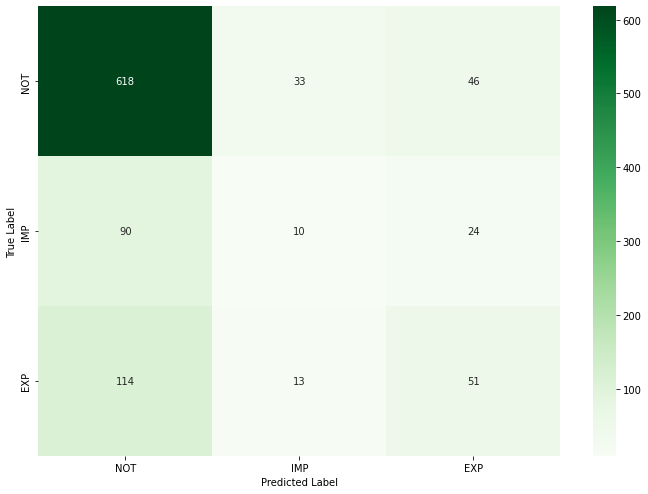

              precision    recall  f1-score   support

           0     0.7518    0.8867    0.8137       697
           1     0.1786    0.0806    0.1111       124
           2     0.4215    0.2865    0.3411       178

    accuracy                         0.6797       999
   macro avg     0.4506    0.4179    0.4220       999
weighted avg     0.6218    0.6797    0.6423       999



In [60]:
"""
Classification report SVM baseline: 

  precision    recall  f1-score   support

            0     0.7518    0.8867    0.8137       697
            1     0.1786    0.0806    0.1111       124
            2     0.4215    0.2865    0.3411       178

     accuracy                         0.6797       999
    macro avg     0.4506    0.4179    0.4220       999
 weighted avg     0.6218    0.6797    0.6423       999
"""


SVM_base = svm_baseline()
labels = ["NOT", "IMP", "EXP"]
heatmap(SVM_base[1], labels, "Greens")
print(SVM_base[0])

Shape train: (5706, 186287)
Shape test: (999, 186287)



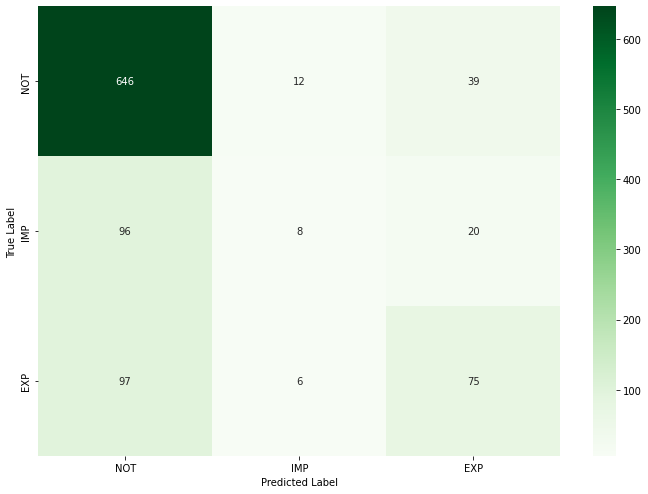

              precision    recall  f1-score   support

           0     0.7700    0.9268    0.8411       697
           1     0.3077    0.0645    0.1067       124
           2     0.5597    0.4213    0.4808       178

    accuracy                         0.7297       999
   macro avg     0.5458    0.4709    0.4762       999
weighted avg     0.6751    0.7297    0.6858       999



In [58]:
"""
Classification report SVM finetuned v1:

               precision    recall  f1-score   support

            0     0.7700    0.9268    0.8411       697
            1     0.3077    0.0645    0.1067       124
            2     0.5597    0.4213    0.4808       178

     accuracy                         0.7297       999
    macro avg     0.5458    0.4709    0.4762       999
 weighted avg     0.6751    0.7297    0.6858       999
"""


SVM_tuned_v1 = svm_finetuned_v1()
labels = ["NOT", "IMP", "EXP"]
heatmap(SVM_tuned_v1[1], labels, "Greens")
print(SVM_tuned_v1[0])

Shape train: (5706, 67515)
Shape test: (999, 67515)



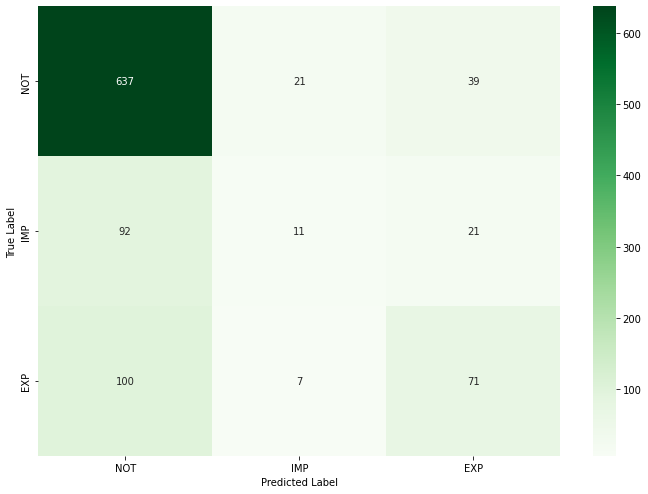

              precision    recall  f1-score   support

           0     0.7684    0.9139    0.8349       697
           1     0.2821    0.0887    0.1350       124
           2     0.5420    0.3989    0.4595       178

    accuracy                         0.7197       999
   macro avg     0.5308    0.4672    0.4765       999
weighted avg     0.6677    0.7197    0.6811       999



In [59]:
"""
Classification report SVM finetuned v2:

               precision    recall  f1-score   support

            0     0.7684    0.9139    0.8349       697
            1     0.2821    0.0887    0.1350       124
            2     0.5420    0.3989    0.4595       178

     accuracy                         0.7197       999
    macro avg     0.5308    0.4672    0.4765       999
 weighted avg     0.6677    0.7197    0.6811       999
"""


SVM_tuned_v2 = svm_finetuned_v2()
labels = ["NOT", "IMP", "EXP"]
heatmap(SVM_tuned_v2[1], labels, "Greens")
print(SVM_tuned_v2[0])

## <span style='font-family:"Times New Roman"'>Results with rbf kernel

In [14]:
"""
Classification report SVM with rbf kernel:

               precision    recall  f1-score   support

            0     0.7000    0.9943    0.8216       697
            1     0.0000    0.0000    0.0000       124
            2     0.5556    0.0281    0.0535       178

     accuracy                         0.6987       999
    macro avg     0.4185    0.3408    0.2917       999
 weighted avg     0.5874    0.6987    0.5827       999
"""
SVM_rbf = svm_rbf()
print(SVM_rbf[0])

Shape train: (5706, 15236)
Shape test: (999, 15236)

              precision    recall  f1-score   support

           0     0.7000    0.9943    0.8216       697
           1     0.0000    0.0000    0.0000       124
           2     0.5556    0.0281    0.0535       178

    accuracy                         0.6987       999
   macro avg     0.4185    0.3408    0.2917       999
weighted avg     0.5874    0.6987    0.5827       999



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa